<a href="https://colab.research.google.com/github/lecongnghi98/traffic-sign-classification/blob/main/cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing all packages

In [99]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import glob
import os

from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

Add `%load_ext cudf.pandas` before importing pandas to speed up operations using GPU

In [100]:
%load_ext cudf.pandas
import pandas as pd
import numpy as np

# Randomly generated dataset of parking violations-
# Define the number of rows
num_rows = 1000000

states = ["NY", "NJ", "CA", "TX"]
violations = ["Double Parking", "Expired Meter", "No Parking",
              "Fire Hydrant", "Bus Stop"]
vehicle_types = ["SUBN", "SDN"]

# Create a date range
start_date = "2022-01-01"
end_date = "2022-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate random data
data = {
    "Registration State": np.random.choice(states, size=num_rows),
    "Violation Description": np.random.choice(violations, size=num_rows),
    "Vehicle Body Type": np.random.choice(vehicle_types, size=num_rows),
    "Issue Date": np.random.choice(dates, size=num_rows),
    "Ticket Number": np.random.randint(1000000000, 9999999999, size=num_rows)
}

# Create a DataFrame
df = pd.DataFrame(data)

# Which parking violation is most commonly committed by vehicles from various U.S states?

(df[["Registration State", "Violation Description"]]  # get only these two columns
 .value_counts()  # get the count of offences per state and per type of offence
 .groupby("Registration State")  # group by state
 .head(1)  # get the first row in each group (the type of offence with the largest count)
 .sort_index()  # sort by state name
 .reset_index()
)

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


,Registration State,Violation Description,count
0,CA,Double Parking,50353
1,NJ,Fire Hydrant,50254
2,NY,Bus Stop,50317
3,TX,No Parking,50437


1. analysing and visualising our data

In [101]:
#path to the csv file containing all labels for traffic signs since folder contains numbers instead of class names
path = '/content/traffic_signs/labels.csv'
df = pd.read_csv(path)

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
df

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


In [104]:
#path to the folder containing our dataset
dataset = '/content/traffic_signs/traffic_Data/DATA'

In [105]:
data = []
entry = []
for filename in os.listdir(dataset):
  entry.append(df['Name'][int(filename)])
  entry.append(int(filename))
  data.append(entry[:2])
  entry.clear()

#making a dataframe so it's easier to display using seaborn
display_data = pd.DataFrame(data,columns=['Name' , 'num_images'])
#display_data

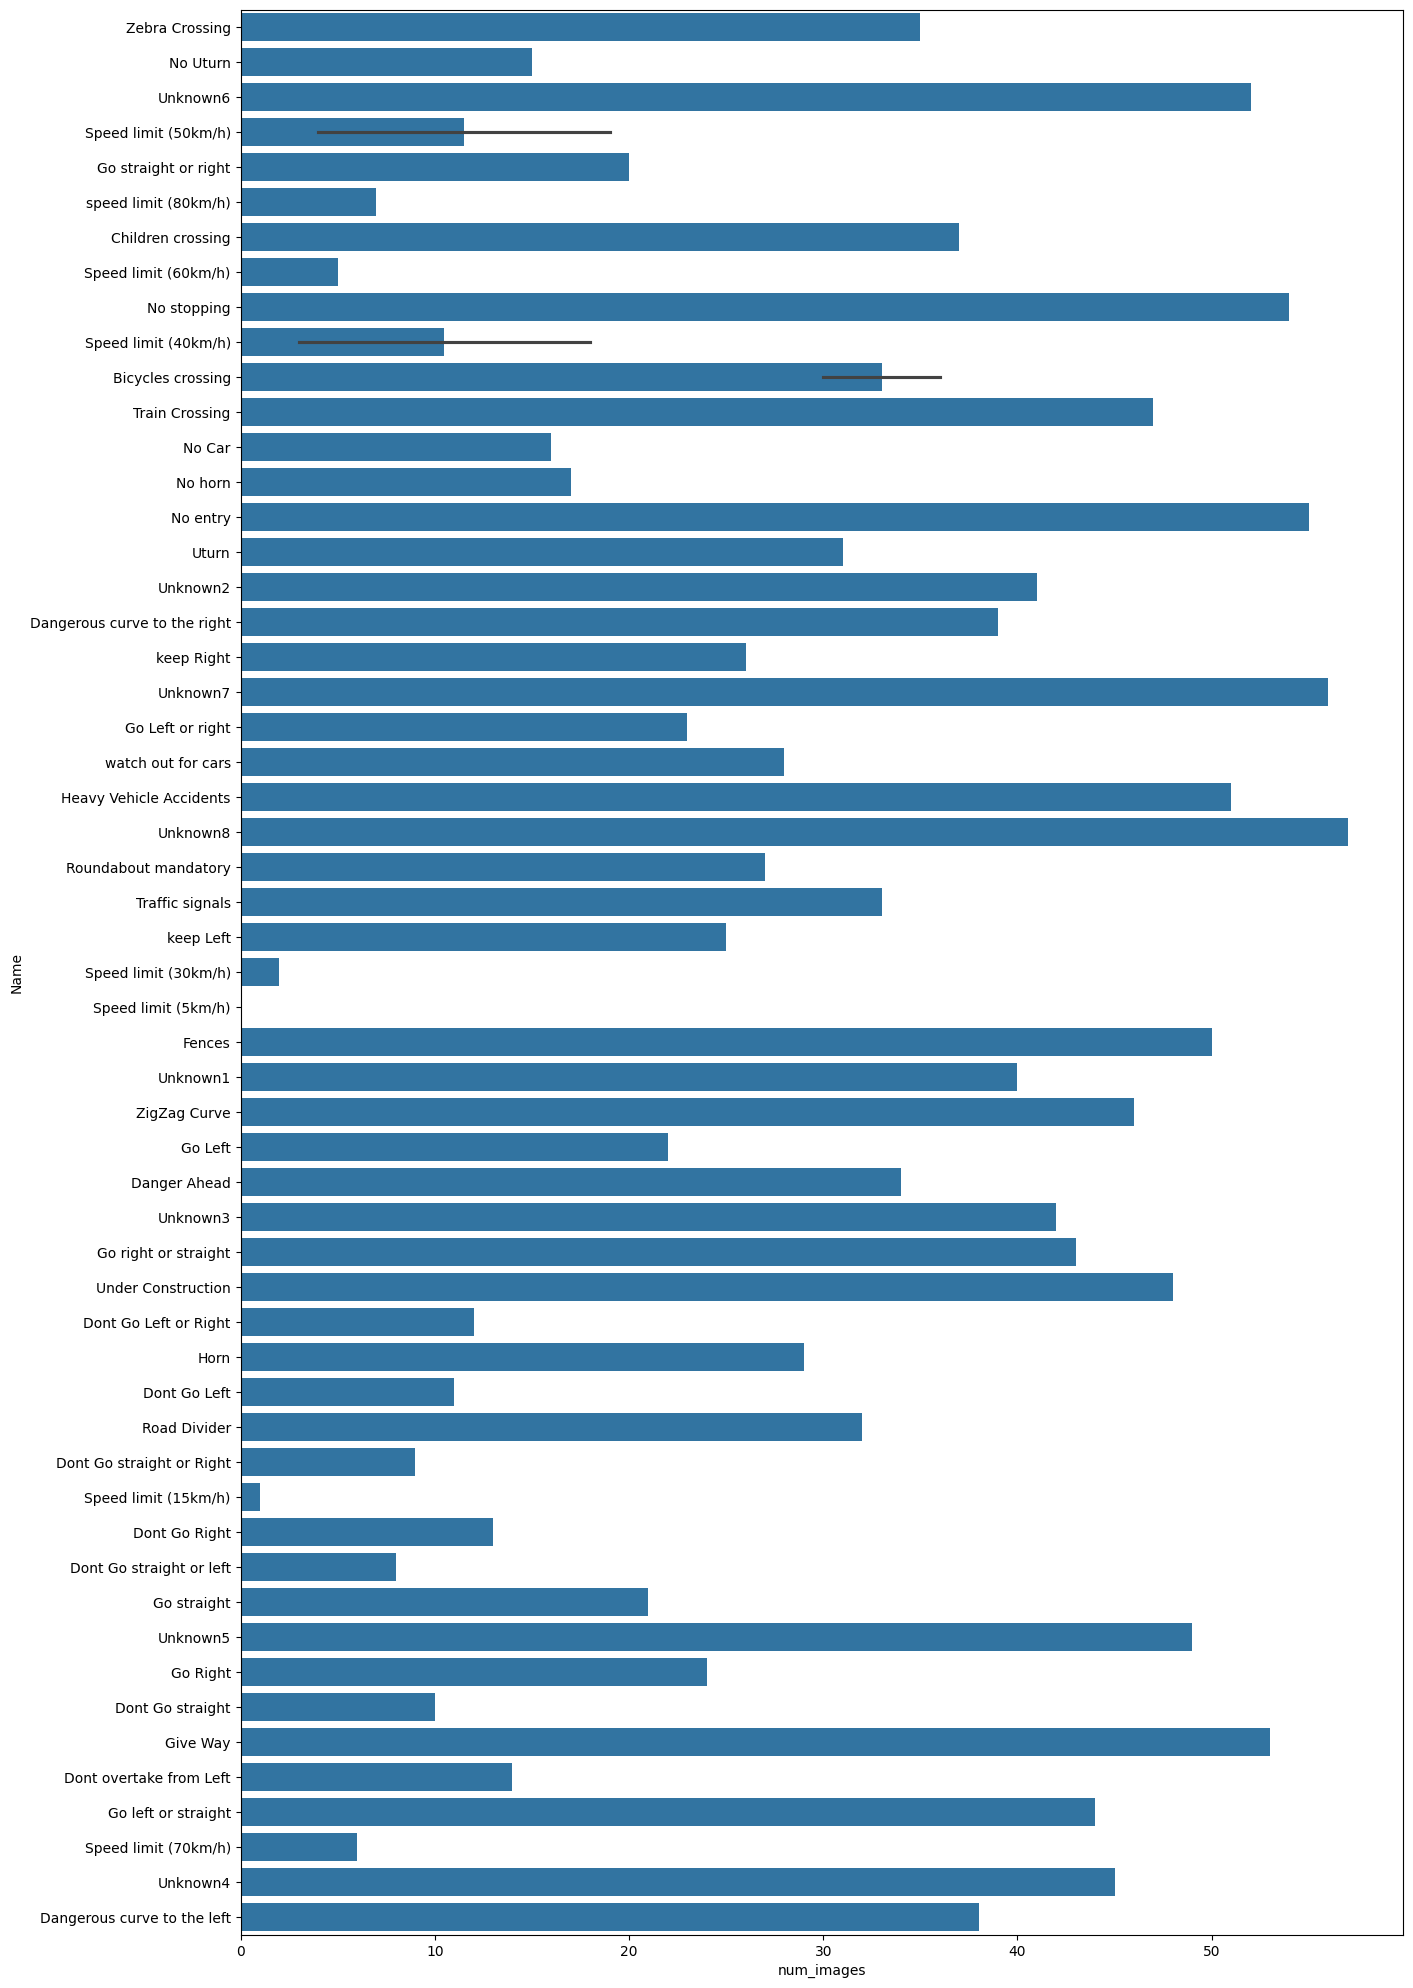

In [106]:
plt.figure(figsize=(15,25))
ax = sns.barplot(x='num_images',y='Name' , data=display_data)

In [107]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,validation_split=0.2,
                                                    subset='training',
                                                    image_size=(224,224),
                                                    seed=123,
                                                    batch_size=32)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.


In [108]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,validation_split=0.2,
                                                    subset='validation',
                                                    image_size=(224,224),
                                                    seed=123,
                                                    batch_size=32)

Found 4170 files belonging to 58 classes.
Using 834 files for validation.


In [109]:
class_numbers = train_ds.class_names
class_names = []
for i in class_numbers:
 class_names.append(df['Name'][int(i)])

#class_names

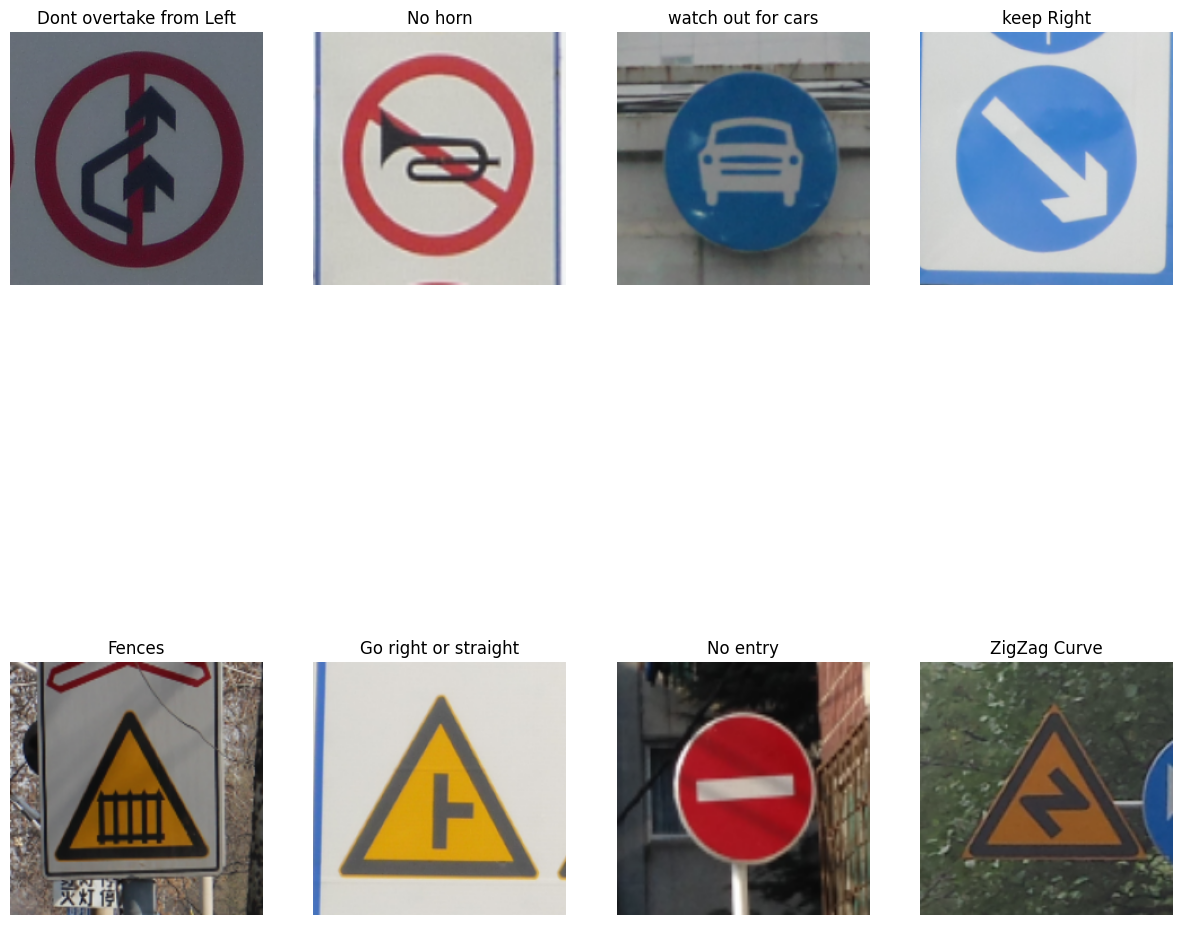

In [110]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

In [111]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
   tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")
  ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Mô hình 1: CNN Đơn Giản (Baseline)

In [112]:
simple_model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),  # Đổi từ 128 -> 224
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(df), activation='softmax')
])

simple_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

simple_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 58)             │         3,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,238,138 (96.28 MB)

 Trainable params: 25,238,138 (96.28 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
early_stop_simple = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist_simple = simple_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop_simple])

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.0710 - loss: 9.7882 - val_accuracy: 0.2566 - val_loss: 2.7694
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.3386 - loss: 2.5347 - val_accuracy: 0.5432 - val_loss: 1.7898
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6049 - loss: 1.5021 - val_accuracy: 0.7794 - val_loss: 0.9755
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8052 - loss: 0.7782 - val_accuracy: 0.8405 - val_loss: 0.6656
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8957 - loss: 0.4397 - val_accuracy: 0.9089 - val_loss: 0.4060
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9359 - loss: 0.2674 - val_accuracy: 0.9365 - val_loss: 0.2893
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9724 - loss: 0.1311 - val_accuracy: 0.9508 - val_loss: 0.2084
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9932 - loss: 0.0622 - val_accu

## Mô hình 2: CNN Cải Tiến

In [114]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df), activation='softmax'))
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,176,442 (42.63 MB)

 Trainable params: 11,176,442 (42.63 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam' , metrics=['accuracy'])

In [116]:
# Set callback functions to early stop training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.1611 - loss: 3.5609 - val_accuracy: 0.4005 - val_loss: 2.2493
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.3251 - loss: 2.4835 - val_accuracy: 0.5168 - val_loss: 1.7764
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.4055 - loss: 2.0855 - val_accuracy: 0.6283 - val_loss: 1.3075
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4701 - loss: 1.7387 - val_accuracy: 0.6691 - val_loss: 1.1609
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5405 - loss: 1.5234 - val_accuracy: 0.6918 - val_loss: 0.9386
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5563 - loss: 1.4523 - val_accuracy: 0.7326 - val_loss: 0.8457
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5803 - loss: 1.3670 - val_accuracy: 0.7470 - val_loss: 0.8126
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.6091 - loss: 1.2482 - val_

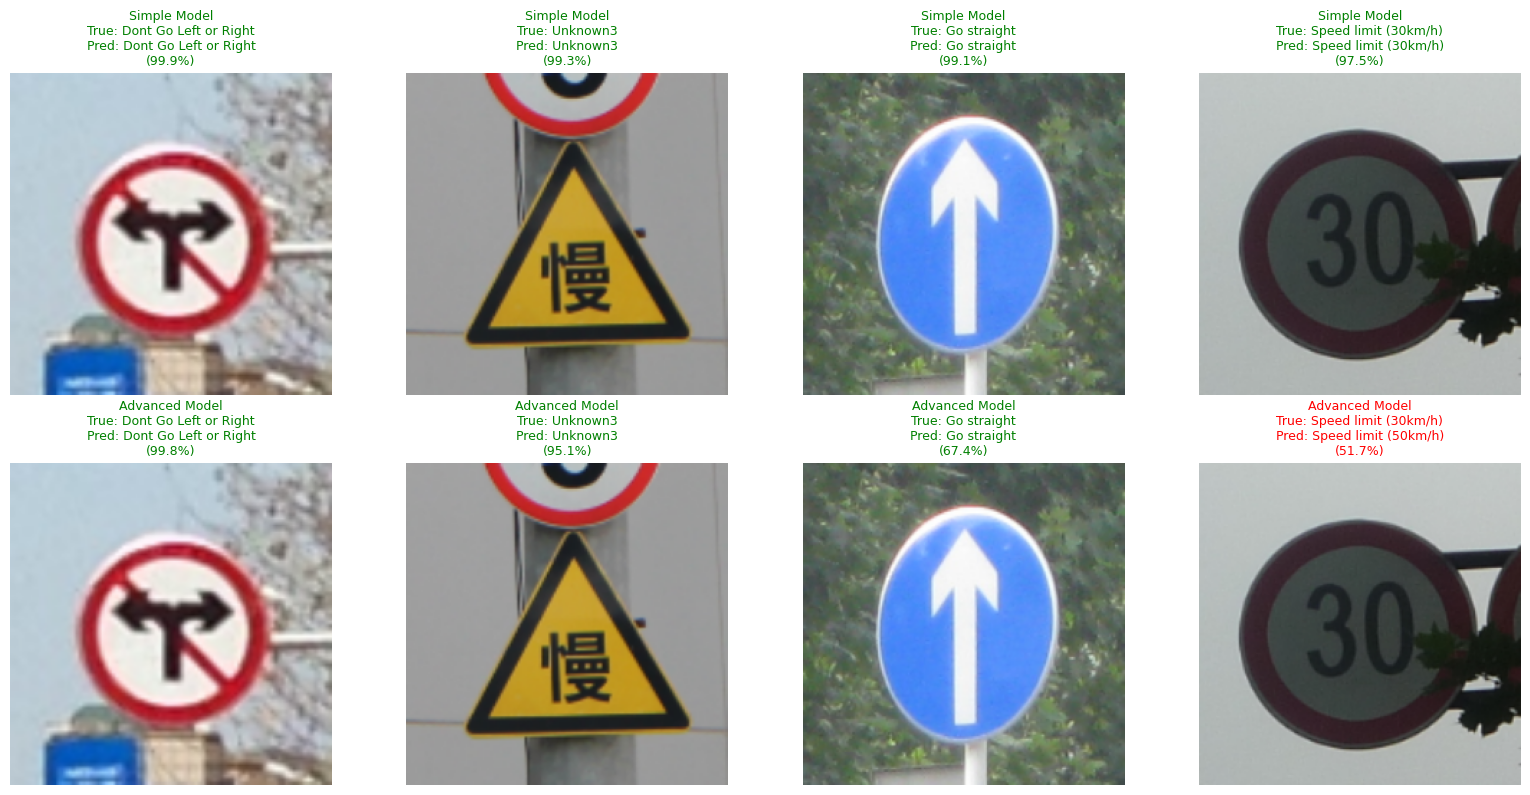

In [117]:
# So sánh trực quan dự đoán của 2 mô hình
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for images, labels in val_ds.take(1):
    simple_predictions = simple_model.predict(images, verbose=0)
    advanced_predictions = model.predict(images, verbose=0)

    for i in range(4):
        # Mô hình đơn giản
        simple_pred_class = np.argmax(simple_predictions[i])
        simple_confidence = np.max(simple_predictions[i]) * 100
        true_class = labels[i].numpy()

        axes[0, i].imshow(images[i].numpy().astype("uint8"))
        color = 'green' if simple_pred_class == true_class else 'red'
        axes[0, i].set_title(f'Simple Model\nTrue: {class_names[true_class]}\nPred: {class_names[simple_pred_class]}\n({simple_confidence:.1f}%)',
                            color=color, fontsize=9)
        axes[0, i].axis("off")

        # Mô hình cải tiến
        advanced_pred_class = np.argmax(advanced_predictions[i])
        advanced_confidence = np.max(advanced_predictions[i]) * 100

        axes[1, i].imshow(images[i].numpy().astype("uint8"))
        color = 'green' if advanced_pred_class == true_class else 'red'
        axes[1, i].set_title(f'Advanced Model\nTrue: {class_names[true_class]}\nPred: {class_names[advanced_pred_class]}\n({advanced_confidence:.1f}%)',
                            color=color, fontsize=9)
        axes[1, i].axis("off")

plt.tight_layout()
plt.show()

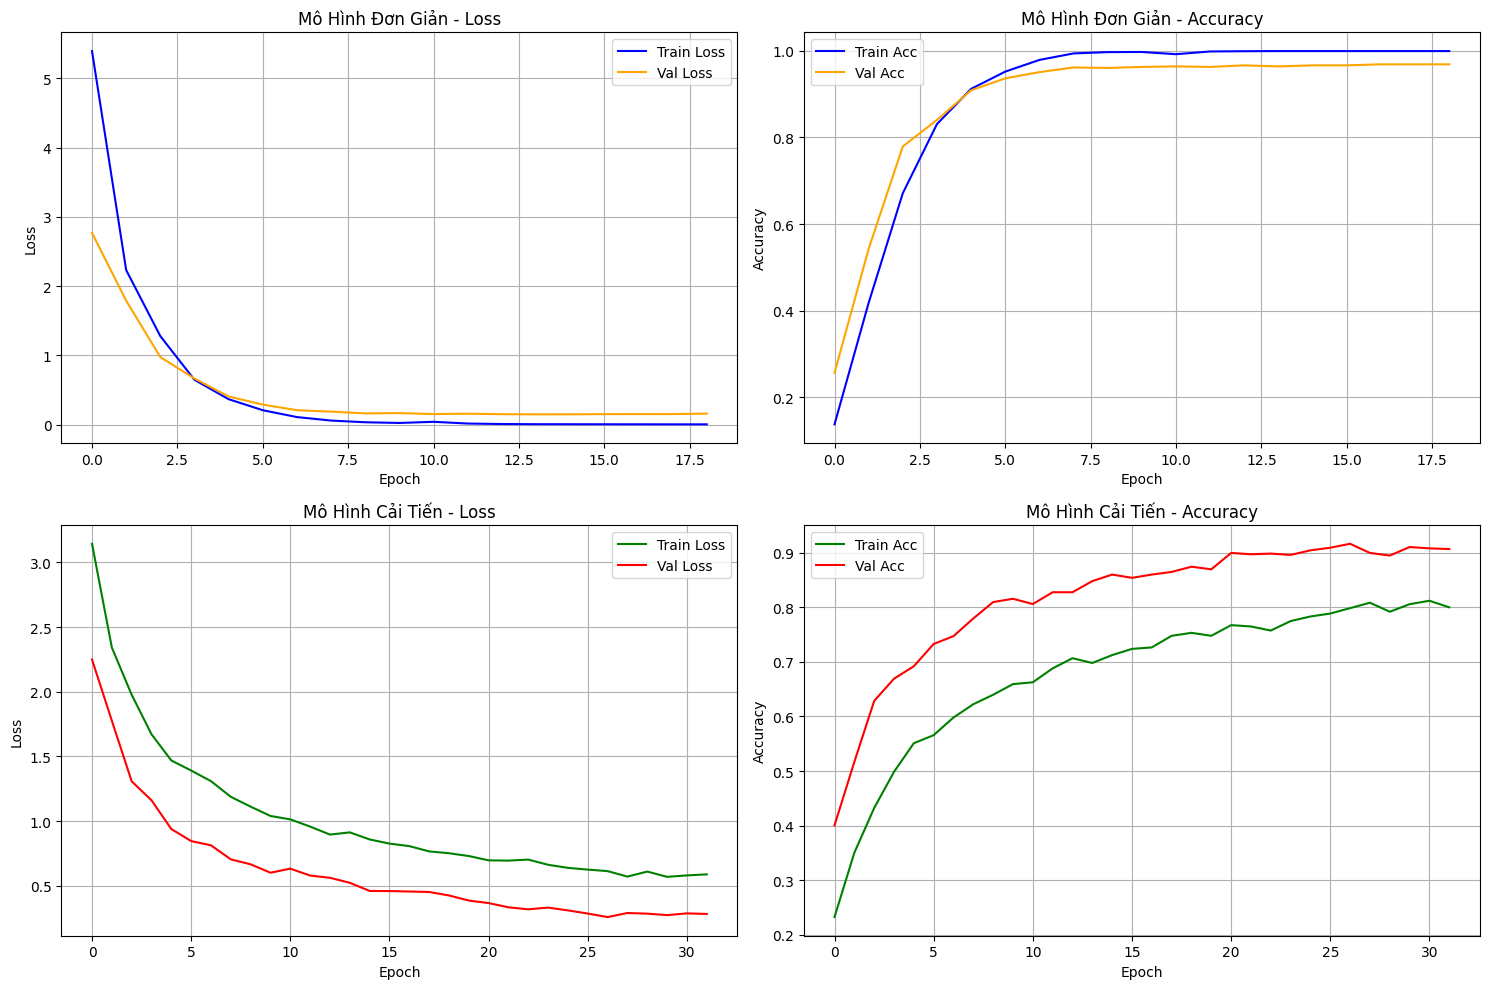

In [118]:
# So sánh biểu đồ training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mô hình đơn giản - Loss
axes[0, 0].plot(hist_simple.history['loss'], label='Train Loss', color='blue')
axes[0, 0].plot(hist_simple.history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Mô Hình Đơn Giản - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Mô hình đơn giản - Accuracy
axes[0, 1].plot(hist_simple.history['accuracy'], label='Train Acc', color='blue')
axes[0, 1].plot(hist_simple.history['val_accuracy'], label='Val Acc', color='orange')
axes[0, 1].set_title('Mô Hình Đơn Giản - Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Mô hình cải tiến - Loss
axes[1, 0].plot(hist.history['loss'], label='Train Loss', color='green')
axes[1, 0].plot(hist.history['val_loss'], label='Val Loss', color='red')
axes[1, 0].set_title('Mô Hình Cải Tiến - Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Mô hình cải tiến - Accuracy
axes[1, 1].plot(hist.history['accuracy'], label='Train Acc', color='green')
axes[1, 1].plot(hist.history['val_accuracy'], label='Val Acc', color='red')
axes[1, 1].set_title('Mô Hình Cải Tiến - Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [119]:
# Đánh giá cả hai mô hình
print("="*60)
print("MÔ HÌNH ĐƠN GIẢN (Baseline)")
print("="*60)
simple_train_loss, simple_train_acc = simple_model.evaluate(train_ds, verbose=0)
simple_val_loss, simple_val_acc = simple_model.evaluate(val_ds, verbose=0)
print(f"Training Accuracy: {simple_train_acc*100:.2f}%")
print(f"Validation Accuracy: {simple_val_acc*100:.2f}%")
print(f"Overfitting Gap: {(simple_train_acc - simple_val_acc)*100:.2f}%")

print("\n" + "="*60)
print("MÔ HÌNH CẢI TIẾN (với Data Augmentation)")
print("="*60)
advanced_train_loss, advanced_train_acc = model.evaluate(train_ds, verbose=0)
advanced_val_loss, advanced_val_acc = model.evaluate(val_ds, verbose=0)
print(f"Training Accuracy: {advanced_train_acc*100:.2f}%")
print(f"Validation Accuracy: {advanced_val_acc*100:.2f}%")
print(f"Overfitting Gap: {(advanced_train_acc - advanced_val_acc)*100:.2f}%")

print("\n" + "="*60)
print("KẾT LUẬN")
print("="*60)
improvement = (advanced_val_acc - simple_val_acc) * 100
print(f"Mô hình cải tiến {'tốt hơn' if improvement > 0 else 'kém hơn'} {abs(improvement):.2f}% so với baseline")
print(f"Tổng số tham số - Đơn giản: {simple_model.count_params():,}")
print(f"Tổng số tham số - Cải tiến: {model.count_params():,}")

MÔ HÌNH ĐƠN GIẢN (Baseline)
Training Accuracy: 99.94%
Validation Accuracy: 96.40%
Overfitting Gap: 3.54%

MÔ HÌNH CẢI TIẾN (với Data Augmentation)
Training Accuracy: 93.65%
Validation Accuracy: 91.61%
Overfitting Gap: 2.04%

KẾT LUẬN
Mô hình cải tiến kém hơn 4.80% so với baseline
Tổng số tham số - Đơn giản: 25,238,138
Tổng số tham số - Cải tiến: 11,176,442


---
## TỔNG KẾT - CNN LÀ GÌ ?

### Nhận Biết Biển Báo Giao Thông

Tưởng tượng bạn dạy một đứa trẻ nhận biết biển báo:

**Cách 1 (Model 1 - Đơn giản):**
```
Bước 1: Nhìn toàn bộ biển báo một lần
Bước 2: Ghi nhớ từng pixel (224×224×3 = 150,528 điểm!)
Bước 3: So sánh với tất cả biển báo đã học

Problem: Phải nhớ quá nhiều chi tiết! (25 triệu "kết nối não")
```

**Cách 2 (Model 2 - Tối ưu):**
```
Bước 1: Tìm các nét đơn giản (đường ngang, dọc, tròn)
Bước 2: Ghép nét thành hình (tam giác, hình tròn, mũi tên)
Bước 3: Kết hợp hình thành ý nghĩa (cấm, báo hiệu, chỉ dẫn)
Bước 4: Quyết định cuối cùng

Chỉ cần nhớ 11 triệu "kết nối não" - ít hơn 2.3 lần!
```

---

## CNN Hoạt Động Như Thế Nào?

### Phép Toán Cốt Lõi

#### 1. **Convolution (Tích Chập)** - "Tìm Đặc Điểm"

**Ví dụ thực tế:**
```
Như dùng kính lúp quét qua ảnh:
 Quét góc trái:  "Có đường thẳng đứng"
 Quét giữa:      "Có hình tròn"  
 Quét góc phải:  "Có tam giác"
```

**Công thức đơn giản:**
```
Mỗi vị trí = Nhìn vùng 3×3 pixels
           → Tìm pattern (cạnh, góc, đường cong)
           → Ghi lại "có/không có" pattern này
```

**Lợi ích:**
- Không cần nhìn toàn bộ ảnh cùng lúc
- Tìm được pattern ở bất kỳ vị trí nào
- Dùng chung bộ lọc → Ít tham số hơn

---

#### 2. **Pooling (Gộp)** - "Tóm Tắt Thông Tin"

**Ví dụ thực tế:**
```
Thay vì nhớ:
"Pixel (0,0)=255, (0,1)=248, (1,0)=252, (1,1)=250"

Chỉ nhớ:
"Vùng này có màu sáng (255)"
```

**Công thức:**
```
Nhóm 4 pixels → Chọn giá trị lớn nhất
[255, 248]  →  max(255, 248, 252, 250) = 255
[252, 250]
```

**Lợi ích:**
- Giảm kích thước ảnh từng bước (224→111→54→26)
- Giữ thông tin quan trọng (giá trị max)
- Làm model "chịu đựng" được khi ảnh dịch chuyển nhẹ

---

#### 3. **Dense (Kết Nối Đầy Đủ)** - "Ra Quyết Định"

**Ví dụ thực tế:**
```
Sau khi tìm được:
- Có hình tam giác đỏ
- Có viền trắng
- Có biểu tượng ở giữa

→ Kết luận: 90% là biển "Cấm đi ngược chiều"
```

**Công thức:**
```
Lấy tất cả đặc điểm đã tìm được
→ Tính "điểm số" cho từng loại biển báo
→ Chọn loại có điểm cao nhất
```

---

## SO SÁNH 2 MODELS

### Model 1: Đơn Giản Nhưng "Lãng Phí"

```python
Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(58, activation='softmax')
])
```

```
Input (224×224×3)
    ↓
[Conv + Pool]  ← Chỉ 1 lần tìm pattern!
    ↓
Flatten (394,272 số)  ← Quá nhiều!
    ↓
Dense(64)  ← 25 TRIỆU kết nối!
    ↓
Output (58 classes)
```

**Vấn đề:**
- Tìm pattern qua 1 lần → pattern đơn giản
- Flatten quá sớm → phải nhớ 394,272 số
- Dense layer khổng lồ → 25M tham số
- Dễ "ghi nhớ" training data → Overfitting 4.53%

**Ví dụ:**
```
Như học sinh chỉ xem sơ qua sách 1 lần,
rồi cố gắng thuộc lòng TOÀN BỘ chi tiết
→ Nhớ nhiều nhưng không hiểu sâu
→ Gặp đề mới (data mới) thì hoang mang!
```

---

### Model 2: Phức Tạp Nhưng "Hiệu Quả"

```python
Sequential([
    # Data Augmentation (training only)
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomFlip("horizontal_and_vertical"),
    
    # Main network
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(58, activation='softmax')
])
```

```
Input (224×224×3)
    ↓
[Conv 32 + Pool]  ← Tìm nét đơn giản
    ↓
[Conv 64 + Pool]  ← Ghép thành hình
    ↓
[Conv 128 + Pool] ← Kết hợp thành ý nghĩa
    ↓
Flatten (86,528 số)  ← Giảm 78%!
    ↓
Dense(128) + Dropout  ← 11 triệu kết nối
    ↓
Output (58 classes)
```

**Ưu điểm:**
- Tìm pattern qua 3 lần → pattern phức tạp, trừu tượng
- Giảm size từng bước → flatten nhỏ gọn
- Dense layer vừa phải → 11M tham số (ít hơn 56%)
- Dropout ngăn "ghi nhớ" → Overfitting chỉ 2.73%

**Ví dụ:**
```
Như học sinh học từ cơ bản đến nâng cao:
1. Học chữ cái đơn (nét đơn giản)
2. Ghép thành từ (pattern phức tạp)
3. Hiểu ý nghĩa câu (ý nghĩa cao cấp)

→ Hiểu sâu, nhớ lâu
→ Gặp đề mới vẫn làm tốt!
```

---

## MODEL 2 TỐT HƠN VÌ...

### Phân Tích Chi Tiết

#### **1. Overfitting Gap - CHỈ SỐ QUAN TRỌNG NHẤT**

```
Model 1:
Training: 97.93%
Validation: 93.41%
Gap: 4.53%  ← "Gian lận" nhiều!

→ Model nhớ training data quá tốt
→ Gặp data mới (validation) → Giảm 4.53%
→ Không tin cậy!
```

```
Model 2:
Training: 95.65%
Validation: 92.93%
Gap: 2.73%  ← "Gian lận" ít hơn!

→ Model học pattern tổng quát
→ Gặp data mới → Chỉ giảm 2.73%
→ Tin cậy hơn!
```

**Giảm Overfitting:**
$$\frac{4.53 - 2.73}{4.53} \times 100\% = 40\% \text{ cải thiện!}$$

---

#### **2. Tham Số - Hiệu Quả Lưu Trữ**

**Tại sao ít tham số tốt hơn?**

```
Ví dụ thực tế:
- Model 1 = Quyển sách 1000 trang (25M params)
- Model 2 = Quyển sách 440 trang (11M params)

Cả 2 cùng kiến thức, nhưng:
- Sách nhỏ dễ mang theo (deploy trên mobile)
- Đọc nhanh hơn (inference speed)
- Ít rủi ro ghi nhớ sai (overfitting)
```

**Breakdown:**

```
Model 1: 99.98% params ở Dense layer
┌──────────────────────────────────┐
│                                  │
│     Dense: 25M (99.98%)          │ ← Tập trung quá!
│                                  │
├──────────────────────────────────┤
│ Conv: 896 (0.02%)                │
└──────────────────────────────────┘

Model 2: Phân bố đều hơn
┌──────────────────────────────────┐
│ Dense: 11M (99.2%)               │
├──────────────────────────────────┤
│ Conv3: 74K (0.7%)                │
├──────────────────────────────────┤
│ Conv2: 18K (0.1%)                │
├──────────────────────────────────┤
│ Conv1: 896 (0.01%)               │
└──────────────────────────────────┘
```

---

#### **3. Validation Accuracy - Có Phải Model 1 Tốt Hơn?**

**KHÔNG!** Đây là bẫy!

```
Model 1: 93.41% val acc, Overfitting 4.53%
Model 2: 92.93% val acc, Overfitting 2.73%

Chênh lệch: 0.48% (KHÔNG ĐÁNG KỂ!)
```

**Giải thích:**

```
Model 1 như học sinh "học vẹt":
- Nhớ 97.93% bài cũ
- Làm bài mới được 93.41%
- Giảm 4.53% → Không hiểu bản chất!

Model 2 như học sinh "học hiểu":
- Nhớ 95.65% bài cũ (vừa đủ)
- Làm bài mới được 92.93%
- Chỉ giảm 2.73% → Hiểu bản chất tốt hơn!
```

**Trong thực tế:**

```
Training data = Đề thi cũ
Validation data = Đề thi mới tương tự
Real-world data = Đề thi thực tế (khác biệt hơn)

→ Model 2 sẽ tốt hơn trên real-world data!
```

---

#### **4. Kiến Trúc - Tại Sao Model 2 Hợp Lý Hơn?**

**Hierarchical Feature Learning (Học từ đơn giản → phức tạp):**

```
Model 1: 1 Conv layer
Input → [Tìm pattern] → Flatten → Decide
         ↑
    Chỉ 1 level!

Chỉ tìm được:
- Đường thẳng
- Đường cong đơn giản
- Góc cạnh cơ bản
```

```
Model 2: 3 Conv layers
Input → [Nét] → [Hình] → [Ý nghĩa] → Decide
         ↓        ↓          ↓
    Level 1   Level 2    Level 3

Tìm được:
Level 1: Cạnh, góc, màu sắc
Level 2: Tam giác, tròn, chữ
Level 3: Biển báo cụ thể, context
```

**Minh họa:**

```
Nhận diện biển "Cấm đi ngược chiều":

Model 1:
[Pixel rời rạc] → [Quyết định]
                     ↓
              "Là biển cấm gì đó"
              (không chắc chắn)

Model 2:
[Pixels] → [Cạnh] → [Hình tròn đỏ] → [Có vạch ngang] → [Quyết định]
   ↓         ↓            ↓                ↓               ↓
Level 0   Level 1     Level 2         Level 3      "Cấm đi ngược!"
                                                   (chắc chắn hơn)
```

---

#### **5. Data Augmentation + Dropout **

**Model 2 có thêm:**

```python
# 1. Data Augmentation
RandomFlip()       → Lật ảnh
RandomRotation()   → Xoay ±36°
RandomZoom()       → Phóng to/nhỏ ±20%

Hiệu quả:
Dataset gốc: 40,000 ảnh
→ Mỗi epoch thấy ảnh khác nhau
→ Effective dataset: 40,000 × 72 = 2,880,000 variations!

# 2. Dropout(0.5)
Random tắt 50% neurons mỗi lần train
→ Không neuron nào "ỷ lại" neurons khác
→ Mỗi neuron phải tự học pattern hữu ích
```

**Ví dụ thực tế:**

```
Không Augmentation (Model 1):
Học sinh chỉ xem 1 dạng đề
→ Gặp đề xoay góc khác → Bối rối

Có Augmentation (Model 2):
Học sinh xem đề ở nhiều góc độ:
- Đề bình thường
- Đề bị xoay
- Đề bị phóng to/nhỏ
- Đề bị lật ngược

→ Gặp đề nào cũng quen!
```
